<a href="https://colab.research.google.com/github/armandossrecife/teste/blob/main/analisa_commits_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!wget https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/requirements.txt

--2023-04-26 21:08:16--  https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21 [text/plain]
Saving to: ‘requirements.txt.1’

requirements.txt.1  100%[===================>]      21  --.-KB/s    in 0s      

2023-04-26 21:08:16 (756 KB/s) - ‘requirements.txt.1’ saved [21/21]



In [83]:
!wget https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/dao.py

--2023-04-26 21:09:00--  https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/dao.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6961 (6.8K) [text/plain]
Saving to: ‘dao.py.1’

dao.py.1            100%[===================>]   6.80K  --.-KB/s    in 0s      

2023-04-26 21:09:01 (46.4 MB/s) - ‘dao.py.1’ saved [6961/6961]



In [84]:
!wget https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/utils.py

--2023-04-26 21:09:51--  https://raw.githubusercontent.com/mining-software-repositories/pilot3/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     469  --.-KB/s    in 0s      

2023-04-26 21:09:52 (10.4 MB/s) - ‘utils.py.1’ saved [469/469]



In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [5]:
import os
import dao
import pydriller
import utils
import datetime

In [6]:
def testa_extensao_java(arquivo):
    if '.java' in arquivo:
        return True
    else:
        return False 

def clona_repositorio(my_repositorio):
    try:
        print('Clona repositório promocity')
        comando = f'git clone {my_repositorio}'
        os.system(comando)
        print('Repositorio clonado com sucesso!')
    except Exception as ex:
        print(f'Erro na clonagem do repositorio {my_repositorio}: {str(ex)}')

In [7]:
clona_repositorio(my_repositorio='https://github.com/armandossrecife/promocity.git')
print('Cria a sessão de banco de dados')
db_session = dao.create_session()
print('Cria as tabelas do banco')
dao.create_tables()
print('Tabelas criadas com sucesso!')

# Cria a colecao de CommitsComplete
myCommitsCompleteCollection = dao.CommitsCompleteCollection(db_session)
# Cria a colecao de FilesComplete
myFilesCompleteCollection = dao.FilesCompleteCollection(db_session)

qtd_commits = 0

tempo1 = datetime.datetime.now()
print('Analisa commits e arquivos modificados. Aguarde...')
for commit in pydriller.Repository('promocity').traverse_commits():
    try:
        currentCommit = dao.CommitComplete(
        name='promocity' + '_' + commit.hash,
        hash=commit.hash,
        msg=commit.msg,
        author=commit.author.name,
        committer=commit.committer.email,
        author_date=commit.author_date,
        author_timezone=commit.author_timezone,
        committer_date=commit.committer_date,
        committer_timezone=commit.committer_timezone,
        branches=utils.convert_list_to_str(commit.branches),
        in_main_branch=commit.in_main_branch,
        merge=commit.merge,
        modified_files=utils.convert_modifield_list_to_str(commit.modified_files),
        parents=utils.convert_list_to_str(commit.parents),
        project_name=commit.project_name,
        project_path=commit.project_path,
        deletions=commit.deletions,
        insertions=commit.insertions,
        lines=commit.lines,
        files=commit.files,
        dmm_unit_size=commit.dmm_unit_size,
        dmm_unit_complexity=commit.dmm_unit_complexity,
        dmm_unit_interfacing=commit.dmm_unit_interfacing)
        # salva dados do commit na tabela de commits do banco do repositorio
        myCommitsCompleteCollection.insert_commit(currentCommit)
        qtd_commits = qtd_commits + 1
        # analisa cada um dos arquivos modificados no commit
        for file in commit.modified_files:
            try:
                if file is not None and file.filename is not None:
                    currentFile = dao.FileComplete(
                                    name=file.filename,
                                    hash=commit.hash,
                                    old_path=file.old_path,
                                    new_path=file.new_path,
                                    filename=file.filename,
                                    is_java=testa_extensao_java(file.filename),
                                    change_type=file.change_type.name,
                                    diff=str(file.diff),
                                    diff_parsed=utils.convert_dictionary_to_str(file.diff_parsed),
                                    added_lines=file.added_lines,
                                    deleted_lines=file.deleted_lines,
                                    source_code=str(file.source_code),
                                    source_code_before=str(file.source_code_before),
                                    methods=utils.convert_list_to_str(file.methods),
                                    methods_before=utils.convert_list_to_str(file.methods_before),
                                    changed_methods=utils.convert_list_to_str(file.changed_methods),
                                    nloc=file.nloc,
                                    complexity=file.complexity,
                                    token_count=file.token_count,
                                    commit_id=myCommitsCompleteCollection.query_commit_hash(commit.hash))
                    myFilesCompleteCollection.insert_file(currentFile)
            except Exception as ex:
                print(f'Erro ao inserir arquivo {file.filename} na tabela de files do banco!: {str(ex)}')
    except Exception as ex:
        print(f'Erro ao salvar commit {commit.hash} no banco : {str(ex)}')
db_session.close()
tempo2 = datetime.datetime.now()
print('Sessão de banco de dados fechada!')
print(f'Quantidade de commits analisados: {qtd_commits}')
print(f'Tempo de análise: {tempo2-tempo1}')

Clona repositório promocity
Repositorio clonado com sucesso!
Cria a sessão de banco de dados
Cria as tabelas do banco
Tabelas criadas com sucesso!
Analisa commits e arquivos modificados. Aguarde...
Sessão de banco de dados fechada!
Quantidade de commits analisados: 91
Tempo de análise: 0:00:18.277892


In [9]:
!ls *.db

my_promocity.db


In [10]:
# 4.2 Carrega as tabelas do banco em dataframes

import pandas as pd
import sqlite3

DATA_BASE='my_promocity.db'
con = sqlite3.connect(DATA_BASE)

my_query_commits = "select * from commitscomplete"
my_query_files = "select * from filescomplete"
my_query_files_commits = "select f.id as 'file_id', f.hash as 'file_hash_commit', f.description as 'file_description', f.is_java as 'file_is_java', f.created_date as 'file_created_date', f.old_path as 'file_old_path', f.new_path as 'file_new_path', f.filename as 'file_filename', f.change_type as 'file_change_type', f.diff as 'file_diff', f.diff_parsed as 'file_diff_parsed', f.added_lines as 'file_added_lines', f.deleted_lines as 'file_deleted_lines', f.source_code as 'file_source_code', f.source_code_before as 'file_source_code_before', f.nloc as 'file_nloc', f.complexity as 'file_complexity', f.token_count as 'file_token_count', f.commit_id as 'file_commit_id', c.* from filescomplete f, commitscomplete c where f.commit_id=c.id"

df_commits_from_db = pd.read_sql_query(my_query_commits, con)
df_files_from_db = pd.read_sql_query(my_query_files, con)
df_files_commits_from_db = pd.read_sql(my_query_files_commits, con)

con.close() 

In [11]:
# Faz alguns ajustes nos dataframes
df_files_from_db['modified_lines'] = df_files_from_db.added_lines + df_files_from_db.deleted_lines

In [12]:
df_files_commits_from_db['modified_lines'] = df_files_commits_from_db.file_added_lines + df_files_commits_from_db.file_deleted_lines

In [14]:
# Lista os commits e seus arquivos modificados
df_commits_from_db[['name', 'modified_files']]

,name,modified_files
0,promocity_e3b8141b1e905e8230ce791e16e3d3abb8b6...,README.md
1,promocity_fc85e473f543f543c68110d62624180fc3b2...,"pom.xml,BackendApplication.java,GenericExcepti..."
2,promocity_4870cfcdffabe16ec28e524da7d707cd74e2...,README.md
3,promocity_46c1d5ecc189124736d3feea3832cf206cc1...,README.md
4,promocity_db4534aacac1e55fbb2f23132db5115c1a7a...,"StoreController.java,UserController.java,Promo..."
...,...,...
86,promocity_4a38184e76082bea6b255db10d9dcbba7b9a...,
87,promocity_5b92311969290653e56c967de7a4e3c2c405...,README.md
88,promocity_5c6f6d9f189adb74b0c692f6100d9b4bfb3b...,README.md
89,promocity_ceb629b75c9c0db2c4feff1d2bd135ce88d6...,README.md


In [16]:
# procura por um commit especifico
df_commits_from_db[['name', 'modified_files']].query("name == 'promocity_fc85e473f543f543c68110d62624180fc3b24606'")

,name,modified_files
1,promocity_fc85e473f543f543c68110d62624180fc3b2...,"pom.xml,BackendApplication.java,GenericExcepti..."


In [17]:
# Lista todos os arquivos e seus commits
df_files_from_db[['name', 'hash']].sort_values('name')

,name,hash
60,AbstractModel.java,415fa2a5d1c5ce0351620b7418d223bbd7805f5c
100,AbstractModel.java,c14eddec7949328d89eeb2ebfc262d9905d15de2
64,AbstractService.java,415fa2a5d1c5ce0351620b7418d223bbd7805f5c
2,BackendApplication.java,fc85e473f543f543c68110d62624180fc3b24606
38,BackendApplication.java,507ade676867670ccfa22b214d6dc13af408c3a3
...,...,...
178,teste-promocity.sh,0e5e2ebd754dc63a2de0fa32f528426a9639b22f
192,teste-promocity.sh,a187c64ce6d4d69713ae2cd04ac5866c64d7d9ce
151,teste-promocity.sh,62dddb7e1c25ac14e9ef51bd361db047818145d3
179,teste.sh,0e5e2ebd754dc63a2de0fa32f528426a9639b22f


In [18]:
# Mostra as Complexidades Ciclomáticas dos arquivos
df_files_commits_from_db[['file_filename', 'file_complexity', 'author_date']].sort_values(by=['file_filename', 'author_date'], ascending=True)

,file_filename,file_complexity,author_date
60,AbstractModel.java,11.0,2018-11-02 16:57:10.000000
100,AbstractModel.java,11.0,2018-11-13 12:19:15.000000
64,AbstractService.java,7.0,2018-11-02 16:57:10.000000
2,BackendApplication.java,1.0,2018-10-31 00:40:14.000000
38,BackendApplication.java,1.0,2018-11-01 19:24:13.000000
...,...,...,...
162,teste-promocity.sh,NaN,2018-11-29 07:55:29.000000
178,teste-promocity.sh,NaN,2018-11-30 08:24:46.000000
192,teste-promocity.sh,NaN,2018-12-02 17:22:06.000000
179,teste.sh,NaN,2018-11-30 08:24:46.000000


In [19]:
# Mostra as complexidades ciclomáticas de um determinado arquivo
df_files_commits_from_db[['file_filename', 'file_complexity', 'author_date']].sort_values(by=['file_filename', 'author_date'], ascending=True).query("file_filename == 'UserController.java'")

,file_filename,file_complexity,author_date
8,UserController.java,6.0,2018-10-31 00:40:14.000000
34,UserController.java,6.0,2018-10-31 15:53:32.000000
45,UserController.java,7.0,2018-11-01 19:24:13.000000
59,UserController.java,8.0,2018-11-02 16:57:10.000000
99,UserController.java,12.0,2018-11-13 12:19:15.000000
116,UserController.java,14.0,2018-11-21 10:22:27.000000
119,UserController.java,16.0,2018-11-21 18:19:28.000000
120,UserController.java,16.0,2018-11-21 18:22:04.000000
122,UserController.java,20.0,2018-11-21 19:41:29.000000
129,UserController.java,21.0,2018-11-21 23:16:42.000000


In [20]:
df_commits_from_db.to_csv('promocity_commits.csv') 
df_files_from_db.to_csv('promocity_files.csv') 
df_files_commits_from_db.to_csv('promocity_files_commits.csv') 

# Calculate the variables used in Case Study (steps 6, 7, 8, 9, 10)

a) Accumulated Modified LOC

b) Cyclomatic Complexity

c) File Occurrency in Commits

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Group by Total Modified Rows

In [22]:
df_files_from_db[['name','modified_lines']]

,name,modified_lines
0,README.md,2
1,pom.xml,62
2,BackendApplication.java,17
3,GenericExceptionMapper.java,20
4,JerseyConfiguration.java,35
...,...,...
226,LICENSE,27
227,README.md,2
228,README.md,6
229,README.md,2


In [23]:
# Lista arquivos ordenados por nome com suas linhas modificadas
df_files_from_db[['name','modified_lines']].sort_values(by=['name'], ascending=True)

,name,modified_lines
60,AbstractModel.java,54
100,AbstractModel.java,1
64,AbstractService.java,57
2,BackendApplication.java,17
38,BackendApplication.java,6
...,...,...
178,teste-promocity.sh,0
192,teste-promocity.sh,11
151,teste-promocity.sh,2
179,teste.sh,12


In [24]:
# Agrupa o df por nome do arquivo
df_groupby_name_modified_lines = df_files_from_db[['name','modified_lines']].groupby('name')

# Soma o total de linhas modificadas de cada arquivo
group_files_modified_lines = df_groupby_name_modified_lines.sum()
group_files_modified_lines

,modified_lines
name,
AbstractModel.java,55
AbstractService.java,57
BackendApplication.java,23
BackendApplicationTests.java,18
Book.java,112
...,...
swagger-5.yaml,1080
swagger.yaml,1286
teste-promocity.sh,44


In [25]:
# Cria um novo df de Linhas de Código Modificadas
df_locm = group_files_modified_lines.copy()
df_locm = df_locm.reset_index()
df_locm

,name,modified_lines
0,AbstractModel.java,55
1,AbstractService.java,57
2,BackendApplication.java,23
3,BackendApplicationTests.java,18
4,Book.java,112
...,...,...
86,swagger-5.yaml,1080
87,swagger.yaml,1286
88,teste-promocity.sh,44
89,teste.sh,12


### All files

In [26]:
# Acrescenta uma coluna File
df_locm['File'] = 'File'
df_boxplot_em = df_locm[['modified_lines', 'File']]

<Axes: xlabel='File', ylabel='modified_lines'>

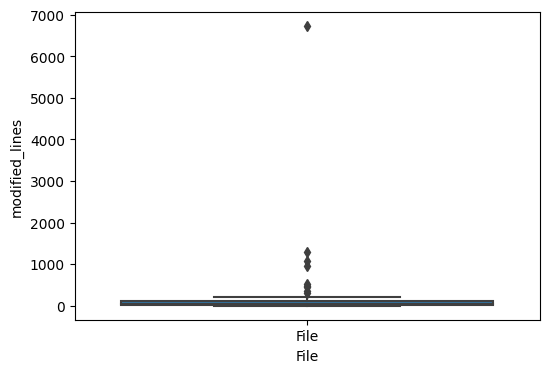

In [27]:
# Boxplot do EM (Esforço de Manutenção de Locs Modificadas). Todos os arquivos do repositório
plt.figure(figsize=(6,4))
sns.boxplot(x='File', y='modified_lines', data=df_boxplot_em)

<Axes: xlabel='File', ylabel='modified_lines'>

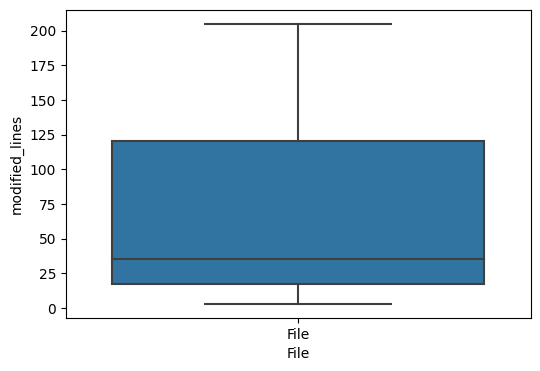

In [28]:
# Remove os arquivos que não foram modificados ao longo do tempo (O linhas modificadas)
df_boxplot_em = df_boxplot_em.drop(df_boxplot_em[df_boxplot_em.modified_lines == 0].index)

plt.figure(figsize=(6,4))
# Constroi o Boxsplot sem os outliers
sns.boxplot(x='File', y='modified_lines', data=df_boxplot_em,  showfliers=False)

In [29]:
list_of_files_modified_lines = group_files_modified_lines.to_dict()
print(f'{ len(list_of_files_modified_lines) }, {list_of_files_modified_lines}')

1, {'modified_lines': {'AbstractModel.java': 55, 'AbstractService.java': 57, 'BackendApplication.java': 23, 'BackendApplicationTests.java': 18, 'Book.java': 112, 'BookController.java': 100, 'BookNotFoundException.java': 23, 'BookService.java': 94, 'Category.java': 10, 'Coupon.java': 181, 'CouponController.java': 203, 'CouponNotFoundException.java': 14, 'CouponService.java': 176, 'CouponsRepository.java': 11, 'CouponsSent.java': 74, 'CouponsService.java': 29, 'Diagrama de Classes Servicos Promocity.asta': 0, 'Diagrama de Classes Servicos Promocity.png': 0, 'GPSPoint.java': 38, 'GenericExceptionMapper.java': 20, 'GeographicArea.java': 93, 'GeradorSenha.java': 33, 'ICouponService.java': 13, 'IPromotionService.java': 13, 'IStoreService.java': 13, 'IUserService.java': 27, 'JerseyConfiguration.java': 54, 'LICENSE': 27, 'LocationStore.java': 79, 'ManipuladorDatas.java': 27, 'Message.java': 20, 'Messenger.java': 31, 'MyStores.java': 34, 'MyStoresRepository.java': 12, 'MyStoresService.java': 26

In [30]:
# Mostra os quatis 
em_q1 = np.percentile(df_boxplot_em.modified_lines, [25])
em_q2 = np.percentile(df_boxplot_em.modified_lines, [50])
em_q3 = np.percentile(df_boxplot_em.modified_lines, [75])
em_q4 = np.percentile(df_boxplot_em.modified_lines, [100])

print(f'Quartis do Total de Linhas Modificadas: Q1: {em_q1}, Q2: {em_q2}, Q3: {em_q3}, Q4: {em_q4}')

Quartis do Total de Linhas Modificadas: Q1: [17.], Q2: [35.5], Q3: [120.75], Q4: [6736.]


### Only .java files

In [31]:
# Cria um df sem os arquivos de Teste
df_locm_no_test = df_locm[(df_locm["name"].str.contains('Test') == False)]

# Cria um df contendo apenas os arquivos .java de implementacao
df_locm_java_impl = df_locm_no_test[df_locm_no_test['name'].str.contains('.java', regex=False)]
df_locm_java_impl

,name,modified_lines,File
0,AbstractModel.java,55,File
1,AbstractService.java,57,File
2,BackendApplication.java,23,File
4,Book.java,112,File
5,BookController.java,100,File
...,...,...,...
68,UserService.java,190,File
69,Users.java,350,File
70,UsersRepository.java,18,File
71,UsersService.java,37,File


<Axes: xlabel='File', ylabel='modified_lines'>

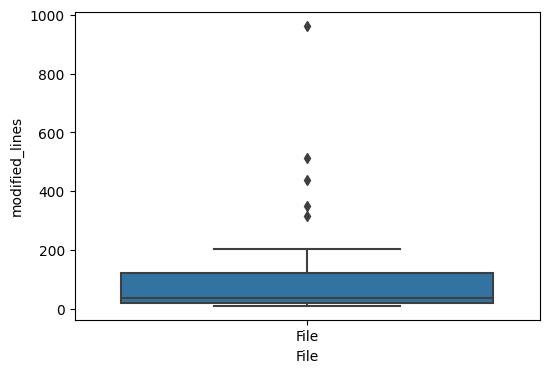

In [32]:
df_boxplot_em_java_impl = df_locm_java_impl[['modified_lines', 'File']]

plt.figure(figsize=(6,4))
sns.boxplot(x='File', y='modified_lines', data=df_boxplot_em_java_impl)

<Axes: xlabel='File', ylabel='modified_lines'>

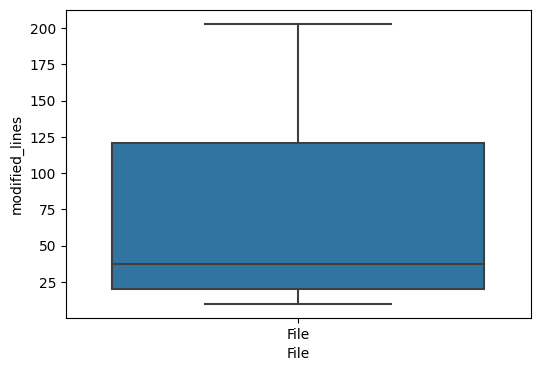

In [33]:
# Remove os arquivos que não foram modificados ao longo do tempo (O linhas modificadas)
df_boxplot_em_java_impl = df_boxplot_em_java_impl.drop(df_boxplot_em_java_impl[df_boxplot_em_java_impl.modified_lines == 0].index)

plt.figure(figsize=(6,4))
# Constroi o Boxsplot sem os outliers
sns.boxplot(x='File', y='modified_lines', data=df_boxplot_em_java_impl,  showfliers=False)

In [34]:
# Mostra os quatis 
em_q1_java_impl = np.percentile(df_boxplot_em_java_impl.modified_lines, [25])
em_q2_java_impl = np.percentile(df_boxplot_em_java_impl.modified_lines, [50])
em_q3_java_impl = np.percentile(df_boxplot_em_java_impl.modified_lines, [75])
em_q4_java_impl = np.percentile(df_boxplot_em_java_impl.modified_lines, [100])

print(f'Quartis do Total de Linhas Modificadas: Q1: {em_q1_java_impl}, Q2: {em_q2_java_impl}, Q3: {em_q3_java_impl}, Q4: {em_q4_java_impl}')

Quartis do Total de Linhas Modificadas: Q1: [20.], Q2: [37.5], Q3: [120.75], Q4: [963.]


## Cyclomatic Complexity over time

In [36]:
# Mostra as Complexidades Ciclomáticas dos arquivos ordenada crescent pelo tempo
df_cc = df_files_commits_from_db[['file_filename', 'file_complexity', 'author_date']].sort_values(by=['file_filename', 'author_date'], ascending=True)
df_cc.query("file_filename == 'UserController.java'")

,file_filename,file_complexity,author_date
8,UserController.java,6.0,2018-10-31 00:40:14.000000
34,UserController.java,6.0,2018-10-31 15:53:32.000000
45,UserController.java,7.0,2018-11-01 19:24:13.000000
59,UserController.java,8.0,2018-11-02 16:57:10.000000
99,UserController.java,12.0,2018-11-13 12:19:15.000000
116,UserController.java,14.0,2018-11-21 10:22:27.000000
119,UserController.java,16.0,2018-11-21 18:19:28.000000
120,UserController.java,16.0,2018-11-21 18:22:04.000000
122,UserController.java,20.0,2018-11-21 19:41:29.000000
129,UserController.java,21.0,2018-11-21 23:16:42.000000


### All files

In [37]:
# Remove files that has not cc
# cc all files
df_cc_temp = df_cc.copy()
df_cc_temp = df_cc_temp[df_cc_temp.file_complexity.notnull()]

Quartis do Total de Linhas Modificadas: Q1: [2.], Q2: [10.], Q3: [19.5], Q4: [59.]


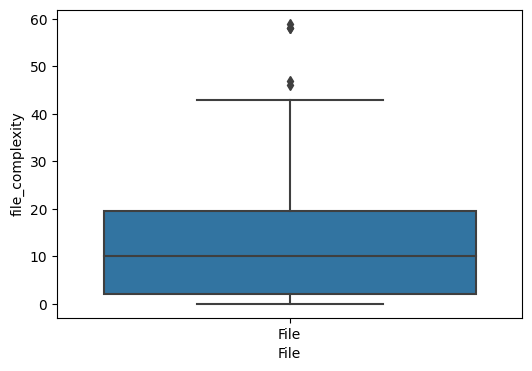

In [38]:
##### Todos os arquivos #####
# Acrescenta uma coluna File
df_cc_temp['File'] = 'File'
df_boxplot_cc_temp = df_cc_temp[['file_complexity', 'File']]

# Boxplot do CC. Todos os arquivos do repositório
plt.figure(figsize=(6,4))
sns.boxplot(x='File', y='file_complexity', data=df_boxplot_cc_temp)

# Mostra os quatis 
em_q1_cc_temp = np.percentile(df_boxplot_cc_temp.file_complexity, [25])
em_q2_cc_temp = np.percentile(df_boxplot_cc_temp.file_complexity, [50])
em_q3_cc_temp = np.percentile(df_boxplot_cc_temp.file_complexity, [75])
em_q4_cc_temp = np.percentile(df_boxplot_cc_temp.file_complexity, [100])

print(f'Quartis do Total de Linhas Modificadas: Q1: {em_q1_cc_temp}, Q2: {em_q2_cc_temp}, Q3: {em_q3_cc_temp}, Q4: {em_q4_cc_temp}')

### Only .java files

Quartis do Total de Linhas Modificadas: Q1: [2.], Q2: [10.], Q3: [20.], Q4: [59.]


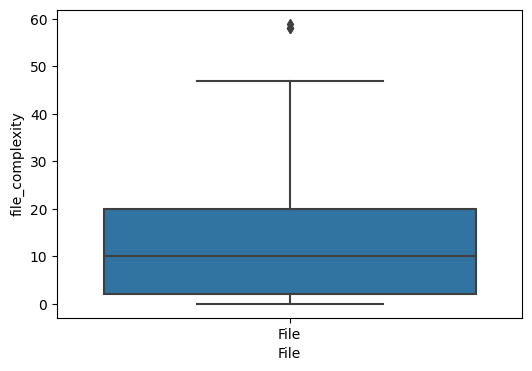

In [39]:
### Apenas os arquivos .java ###
# Cria um df sem os arquivos de Teste
df_cc_temp_no_test = df_cc_temp[(df_cc_temp["file_filename"].str.contains('Test') == False)]

# Cria um df contendo apenas os arquivos .java de implementacao
df_cc_temp_java_impl = df_cc_temp_no_test[df_cc_temp_no_test['file_filename'].str.contains('.java', regex=False)]

df_cc_temp_boxplot_em_java_impl = df_cc_temp_java_impl[['file_complexity', 'File']]

plt.figure(figsize=(6,4))
sns.boxplot(x='File', y='file_complexity', data=df_cc_temp_boxplot_em_java_impl)

# Mostra os quatis 
em_q1_cc_temp_java_impl = np.percentile(df_cc_temp_boxplot_em_java_impl.file_complexity, [25])
em_q2_cc_temp_java_impl = np.percentile(df_cc_temp_boxplot_em_java_impl.file_complexity, [50])
em_q3_cc_temp_java_impl = np.percentile(df_cc_temp_boxplot_em_java_impl.file_complexity, [75])
em_q4_cc_temp_java_impl = np.percentile(df_cc_temp_boxplot_em_java_impl.file_complexity, [100])

print(f'Quartis do Total de Linhas Modificadas: Q1: {em_q1_cc_temp_java_impl}, Q2: {em_q2_cc_temp_java_impl}, Q3: {em_q3_cc_temp_java_impl}, Q4: {em_q4_cc_temp_java_impl}')

## File Occurrency in Commits

In [40]:
# calcula frequência dos arquivos na faixa de commits analisados
list_of_files_frequency_in_commits = {}

# Dataframe agrupados por arquivos e seus commits
df_groupby_name = df_files_from_db[['name', 'hash']].groupby('name')

print(f'Quantidade de grupos: {df_groupby_name.ngroups}')
print(f'Grupos: {df_groupby_name.groups}')

Quantidade de grupos: 91
Grupos: {'AbstractModel.java': [60, 100], 'AbstractService.java': [64], 'BackendApplication.java': [2, 38], 'BackendApplicationTests.java': [30, 224], 'Book.java': [9], 'BookController.java': [6], 'BookNotFoundException.java': [20], 'BookService.java': [15], 'Category.java': [10], 'Coupon.java': [11, 46, 73, 130, 132, 155, 161, 174], 'CouponController.java': [71, 194], 'CouponNotFoundException.java': [21], 'CouponService.java': [16, 76], 'CouponsRepository.java': [75], 'CouponsSent.java': [40, 55], 'CouponsService.java': [77], 'Diagrama de Classes Servicos Promocity.asta': [187], 'Diagrama de Classes Servicos Promocity.png': [188], 'GPSPoint.java': [52], 'GenericExceptionMapper.java': [3], 'GeographicArea.java': [53, 68], 'GeradorSenha.java': [126], 'ICouponService.java': [25], 'IPromotionService.java': [26], 'IStoreService.java': [27], 'IUserService.java': [28, 67], 'JerseyConfiguration.java': [4, 39, 70, 83, 97, 111], 'LICENSE': [226], 'LocationStore.java': [

In [41]:
df_files_from_db[['name', 'hash']].query("name=='.gitignore'")

,name,hash


In [42]:
group_files = df_groupby_name.size()
print(group_files)
print('')
list_of_files_frequency_in_commits = group_files.to_dict()
print(f'{ len(list_of_files_frequency_in_commits) }, {list_of_files_frequency_in_commits}')

name
AbstractModel.java              2
AbstractService.java            1
BackendApplication.java         2
BackendApplicationTests.java    2
Book.java                       1
                               ..
swagger-5.yaml                  1
swagger.yaml                    2
teste-promocity.sh              6
teste.sh                        1
ufc.sh                          1
Length: 91, dtype: int64

91, {'AbstractModel.java': 2, 'AbstractService.java': 1, 'BackendApplication.java': 2, 'BackendApplicationTests.java': 2, 'Book.java': 1, 'BookController.java': 1, 'BookNotFoundException.java': 1, 'BookService.java': 1, 'Category.java': 1, 'Coupon.java': 8, 'CouponController.java': 2, 'CouponNotFoundException.java': 1, 'CouponService.java': 2, 'CouponsRepository.java': 1, 'CouponsSent.java': 2, 'CouponsService.java': 1, 'Diagrama de Classes Servicos Promocity.asta': 1, 'Diagrama de Classes Servicos Promocity.png': 1, 'GPSPoint.java': 1, 'GenericExceptionMapper.java': 1, 'GeographicArea.ja

In [43]:
# Cria um df contendo o arquivo e sua frequencia de commits
df_fc = pd.DataFrame({'name':group_files.index, 'frequency_commits': group_files.values})
df_fc

,name,frequency_commits
0,AbstractModel.java,2
1,AbstractService.java,1
2,BackendApplication.java,2
3,BackendApplicationTests.java,2
4,Book.java,1
...,...,...
86,swagger-5.yaml,1
87,swagger.yaml,2
88,teste-promocity.sh,6
89,teste.sh,1


### All files

In [44]:
df_boxplot_fc = df_fc
# Acrescenta a coluna File
df_boxplot_fc['File'] = 'File'
df_boxplot_fc

,name,frequency_commits,File
0,AbstractModel.java,2,File
1,AbstractService.java,1,File
2,BackendApplication.java,2,File
3,BackendApplicationTests.java,2,File
4,Book.java,1,File
...,...,...,...
86,swagger-5.yaml,1,File
87,swagger.yaml,2,File
88,teste-promocity.sh,6,File
89,teste.sh,1,File


In [45]:
# Remove as frequencias muito baixas (total de commits < 10)
df_boxplot_fc = df_boxplot_fc.drop(df_boxplot_fc[df_boxplot_fc.frequency_commits < 10].index)
df_boxplot_fc

,name,frequency_commits,File
47,README.md,13,File
56,StoreController.java,11,File
65,UserController.java,22,File
66,UserLocationMonitoring.java,11,File
69,Users.java,11,File


<Axes: xlabel='File', ylabel='frequency_commits'>

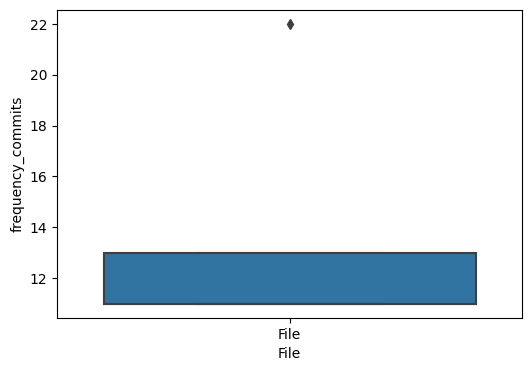

In [46]:
plt.figure(figsize=(6,4))

sns.boxplot(x='File', y='frequency_commits', data=df_boxplot_fc)

<Axes: xlabel='File', ylabel='frequency_commits'>

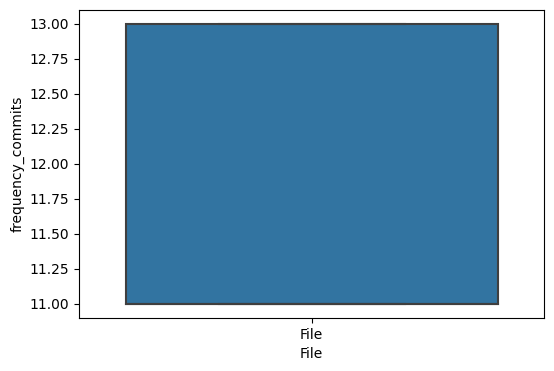

In [47]:
plt.figure(figsize=(6,4))

# Constroi o Boxsplot sem os outliers
sns.boxplot(x='File', y='frequency_commits', data=df_boxplot_fc, showfliers=False)

In [48]:
fc_q1 = np.percentile(df_boxplot_fc.frequency_commits , [25])
fc_q2 = np.percentile(df_boxplot_fc.frequency_commits , [50])
fc_q3 = np.percentile(df_boxplot_fc.frequency_commits , [75])
fc_q4 = np.percentile(df_boxplot_fc.frequency_commits , [100])

print(f'Quartis da Frequencia de Commits Q1: {fc_q1}, Q2: {fc_q2}, Q3: {fc_q3}, Q4: {fc_q4}')

Quartis da Frequencia de Commits Q1: [11.], Q2: [11.], Q3: [13.], Q4: [22.]


### Only .java files

In [49]:
# Cria um df sem os arquivos de Teste
df_fc_no_test = df_fc[(df_fc["name"].str.contains('Test') == False)]

# Cria um df contendo apenas os arquivos .java de implementacao
df_fc_java_impl = df_fc_no_test[df_fc_no_test['name'].str.contains('.java', regex=False)]
df_fc_java_impl

,name,frequency_commits,File
0,AbstractModel.java,2,File
1,AbstractService.java,1,File
2,BackendApplication.java,2,File
4,Book.java,1,File
5,BookController.java,1,File
...,...,...,...
68,UserService.java,3,File
69,Users.java,11,File
70,UsersRepository.java,2,File
71,UsersService.java,2,File


<Axes: xlabel='File', ylabel='frequency_commits'>

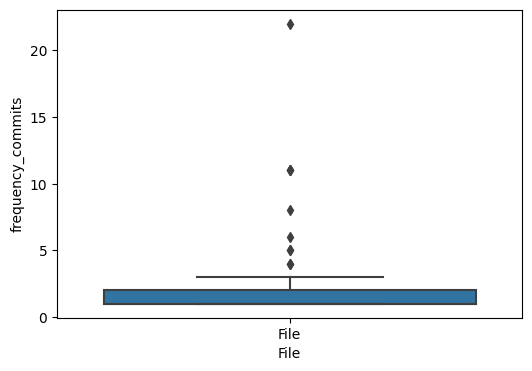

In [50]:
df_boxplot_fc_java_impl = df_fc_java_impl[['frequency_commits', 'File']]

plt.figure(figsize=(6,4))
sns.boxplot(x='File', y='frequency_commits', data=df_boxplot_fc_java_impl)

<Axes: xlabel='File', ylabel='frequency_commits'>

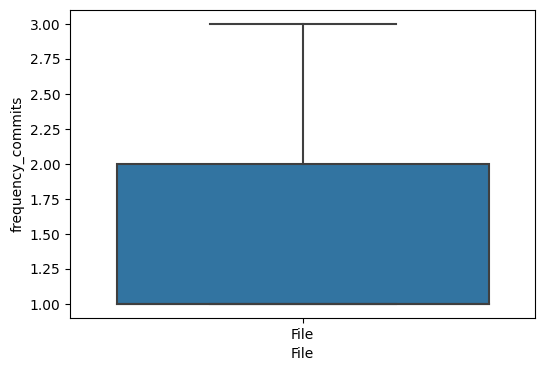

In [51]:
plt.figure(figsize=(6,4))

# Constroi o Boxsplot sem os outliers
sns.boxplot(x='File', y='frequency_commits', data=df_boxplot_fc_java_impl, showfliers=False)

In [53]:
# Remove as frequencias muito baixas (total de commits < 3)
df_boxplot_fc_java_impl2 = df_boxplot_fc_java_impl.drop(df_boxplot_fc_java_impl[df_boxplot_fc_java_impl.frequency_commits < 3].index)
df_boxplot_fc_java_impl2

,frequency_commits,File
9,8,File
26,6,File
38,5,File
40,4,File
41,3,File
49,3,File
55,4,File
56,11,File
58,5,File
64,3,File


<Axes: xlabel='File', ylabel='frequency_commits'>

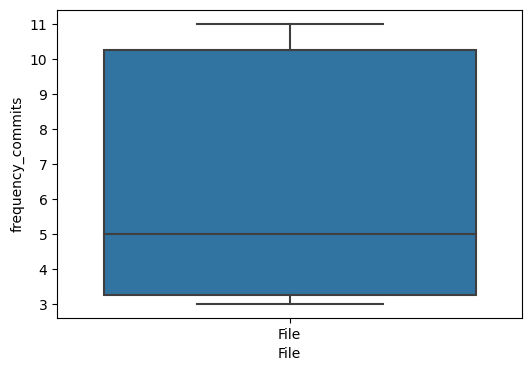

In [54]:
plt.figure(figsize=(6,4))

# Constroi o Boxsplot sem os outliers
sns.boxplot(x='File', y='frequency_commits', data=df_boxplot_fc_java_impl2, showfliers=False)

In [55]:
fc_q1_java_impl = np.percentile(df_boxplot_fc_java_impl2.frequency_commits , [25])
fc_q2_java_impl = np.percentile(df_boxplot_fc_java_impl2.frequency_commits , [50])
fc_q3_java_impl = np.percentile(df_boxplot_fc_java_impl2.frequency_commits , [75])
fc_q4_java_impl = np.percentile(df_boxplot_fc_java_impl2.frequency_commits , [100])

print(f'Quartis da Frequencia de Commits Q1: {fc_q1_java_impl}, Q2: {fc_q2_java_impl}, Q3: {fc_q3_java_impl}, Q4: {fc_q4_java_impl}')

Quartis da Frequencia de Commits Q1: [3.25], Q2: [5.], Q3: [10.25], Q4: [22.]


# Merge of Data from EM (Accumulated Modified LOCs) and FC (File Occurrency in Commits) (step 11)

In [56]:
# EM from df_arquivos_mais_locs_modificados -> df_locm
print('LOCM')
df_locm.info()

print('')

print('FC')
# FC from df_arquivos_mais_modificados -> df_fc
df_fc.info()

LOCM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            91 non-null     object
 1   modified_lines  91 non-null     int64 
 2   File            91 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB

FC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               91 non-null     object
 1   frequency_commits  91 non-null     int64 
 2   File               91 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


In [57]:
df_em_fc = df_locm[['name','modified_lines']]
df_em_fc['frequency_commits'] = df_fc['frequency_commits']
df_em_fc

,name,modified_lines,frequency_commits
0,AbstractModel.java,55,2
1,AbstractService.java,57,1
2,BackendApplication.java,23,2
3,BackendApplicationTests.java,18,2
4,Book.java,112,1
...,...,...,...
86,swagger-5.yaml,1080,1
87,swagger.yaml,1286,2
88,teste-promocity.sh,44,6
89,teste.sh,12,1


In [58]:
df_fator_multiplicacao = df_em_fc.copy()
df_fator_multiplicacao['factor1'] = df_fator_multiplicacao['modified_lines'] * df_fator_multiplicacao['frequency_commits']
df_fator_multiplicacao

,name,modified_lines,frequency_commits,factor1
0,AbstractModel.java,55,2,110
1,AbstractService.java,57,1,57
2,BackendApplication.java,23,2,46
3,BackendApplicationTests.java,18,2,36
4,Book.java,112,1,112
...,...,...,...,...
86,swagger-5.yaml,1080,1,1080
87,swagger.yaml,1286,2,2572
88,teste-promocity.sh,44,6,264
89,teste.sh,12,1,12


# Generates Scatter plots between EM (Changes of LoCs) and FC (Frequency of Commits) (steps 12, 13)

## All files

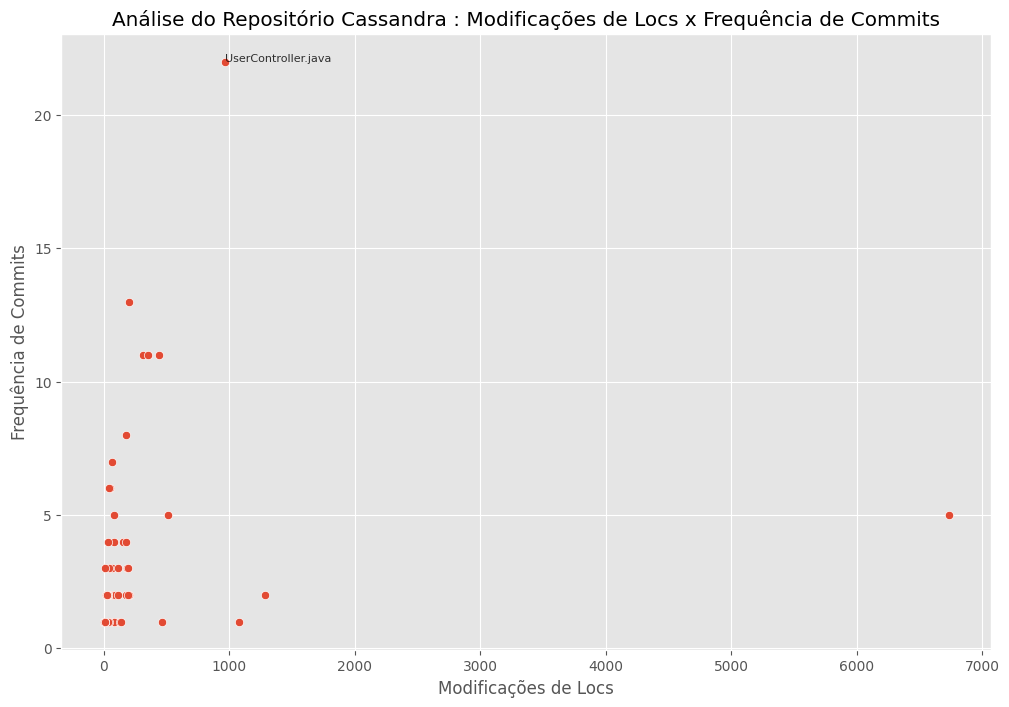

In [59]:
plt.style.use('ggplot')

plt.figure(figsize=(12,8))
sns.scatterplot(data=df_em_fc, x='modified_lines', y='frequency_commits')

abbr={'titulo':'Modificações de LoCs x Frequência de Commits', 'modified_lines':'Modificações de Locs', 'frequency_commits':'Frequência de Commits'}

plt.title(f"Análise do Repositório Cassandra : {abbr['modified_lines']} x {abbr['frequency_commits']}")
plt.xlabel(abbr['modified_lines'])
plt.ylabel(abbr['frequency_commits'])
          
for i in range(df_em_fc.shape[0]):
  if df_em_fc.modified_lines[i] > em_q3 and df_em_fc.frequency_commits[i] > fc_q3: 
    plt.text(df_em_fc.modified_lines[i], y=df_em_fc.frequency_commits[i], s=df_em_fc.name[i], alpha=0.8, fontsize=8)

plt.show()

In [60]:
import plotly.graph_objects as go

#https://plotly.com/python/line-and-scatter/
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
#https://plotly.com/python/creating-and-updating-figures/
#https://plotly.com/python/setting-graph-size/
#https://plotly.com/python/axes/
#https://www.linkedin.com/pulse/complete-introduction-plotly-from-beginner-advanced-pranjall-kumar

# array de complexidade ciclomatica
array_cc = np.random.randint(1, 300, size=300)
# Add traces
fig = go.Figure(data=go.Scatter(
                    x=df_em_fc.modified_lines, 
                    y=df_em_fc.frequency_commits,
                    mode='markers',
                    name='markers',
                    customdata=df_em_fc.name,
                    hovertext=df_em_fc.name, 
                    marker=dict(size=8, color=array_cc, colorscale='Blues', showscale=True, colorbar={"title": 'CC'})
                    )
                  )

fig.update_layout({"title_text": "LoC Mofications x Commit Frequency"},     
                  width=1000,
                  height=600
                  )
fig.update_xaxes(
        title_text = "LoC Modifications",
        title_font = {"size": 10}
        )
fig.update_yaxes(
        title_text = "Commit Frequency",
        title_font = {"size": 10}
        )

fig.show()

## only .java files

In [61]:
# Cria um df sem os arquivos de Teste
df_em_fc_no_test = df_em_fc[(df_em_fc["name"].str.contains('Test') == False)]

# Cria um df contendo apenas os arquivos .java de implementacao
df_em_fc_java_impl = df_em_fc_no_test[df_em_fc_no_test['name'].str.contains('.java', regex=False)]
df_em_fc_java_impl

,name,modified_lines,frequency_commits
0,AbstractModel.java,55,2
1,AbstractService.java,57,1
2,BackendApplication.java,23,2
4,Book.java,112,1
5,BookController.java,100,1
...,...,...,...
68,UserService.java,190,3
69,Users.java,350,11
70,UsersRepository.java,18,2
71,UsersService.java,37,2


In [62]:
df_fator_multiplicacao_em_fc_java_impl = df_em_fc_java_impl.copy()
df_fator_multiplicacao_em_fc_java_impl['factor1'] = df_fator_multiplicacao_em_fc_java_impl['modified_lines'] * df_fator_multiplicacao_em_fc_java_impl['frequency_commits']
df_fator_multiplicacao_em_fc_java_impl

,name,modified_lines,frequency_commits,factor1
0,AbstractModel.java,55,2,110
1,AbstractService.java,57,1,57
2,BackendApplication.java,23,2,46
4,Book.java,112,1,112
5,BookController.java,100,1,100
...,...,...,...,...
68,UserService.java,190,3,570
69,Users.java,350,11,3850
70,UsersRepository.java,18,2,36
71,UsersService.java,37,2,74


In [63]:
s = df_fator_multiplicacao_em_fc_java_impl.copy()
s

,name,modified_lines,frequency_commits,factor1
0,AbstractModel.java,55,2,110
1,AbstractService.java,57,1,57
2,BackendApplication.java,23,2,46
4,Book.java,112,1,112
5,BookController.java,100,1,100
...,...,...,...,...
68,UserService.java,190,3,570
69,Users.java,350,11,3850
70,UsersRepository.java,18,2,36
71,UsersService.java,37,2,74


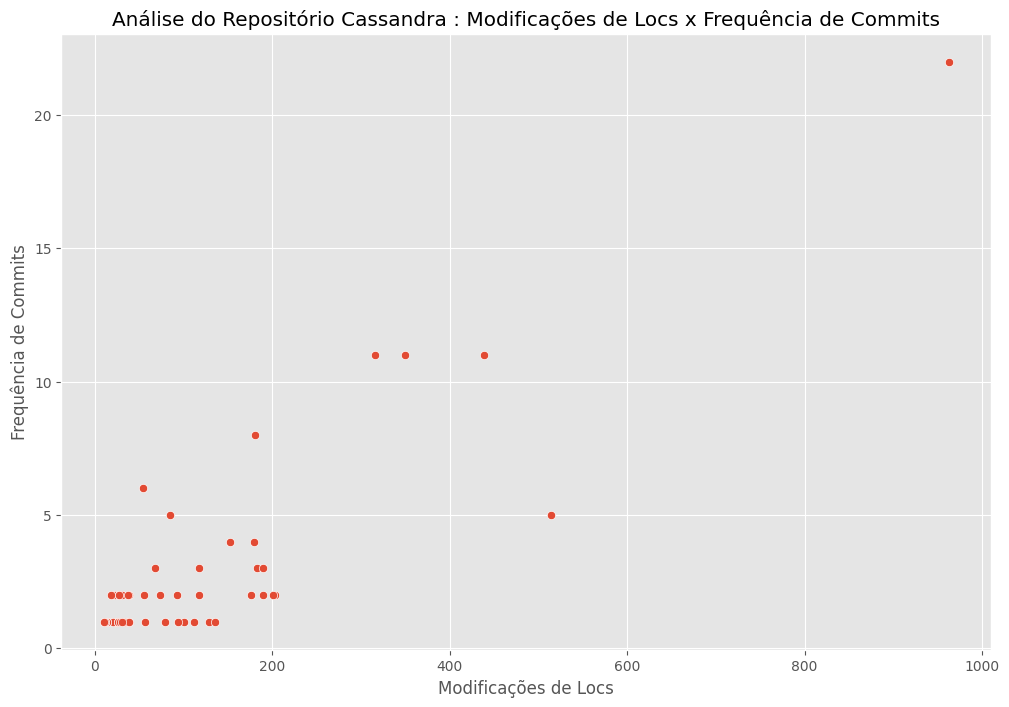

In [64]:
plt.style.use('ggplot')

plt.figure(figsize=(12,8))
sns.scatterplot(data=df_em_fc_java_impl, x='modified_lines', y='frequency_commits')

abbr={'titulo':'Modificações de LoCs x Frequência de Commits', 'modified_lines':'Modificações de Locs', 'frequency_commits':'Frequência de Commits'}

plt.title(f"Análise do Repositório Cassandra : {abbr['modified_lines']} x {abbr['frequency_commits']}")
plt.xlabel(abbr['modified_lines'])
plt.ylabel(abbr['frequency_commits'])

plt.show()

<ipython-input-65-50ff33daaffd>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



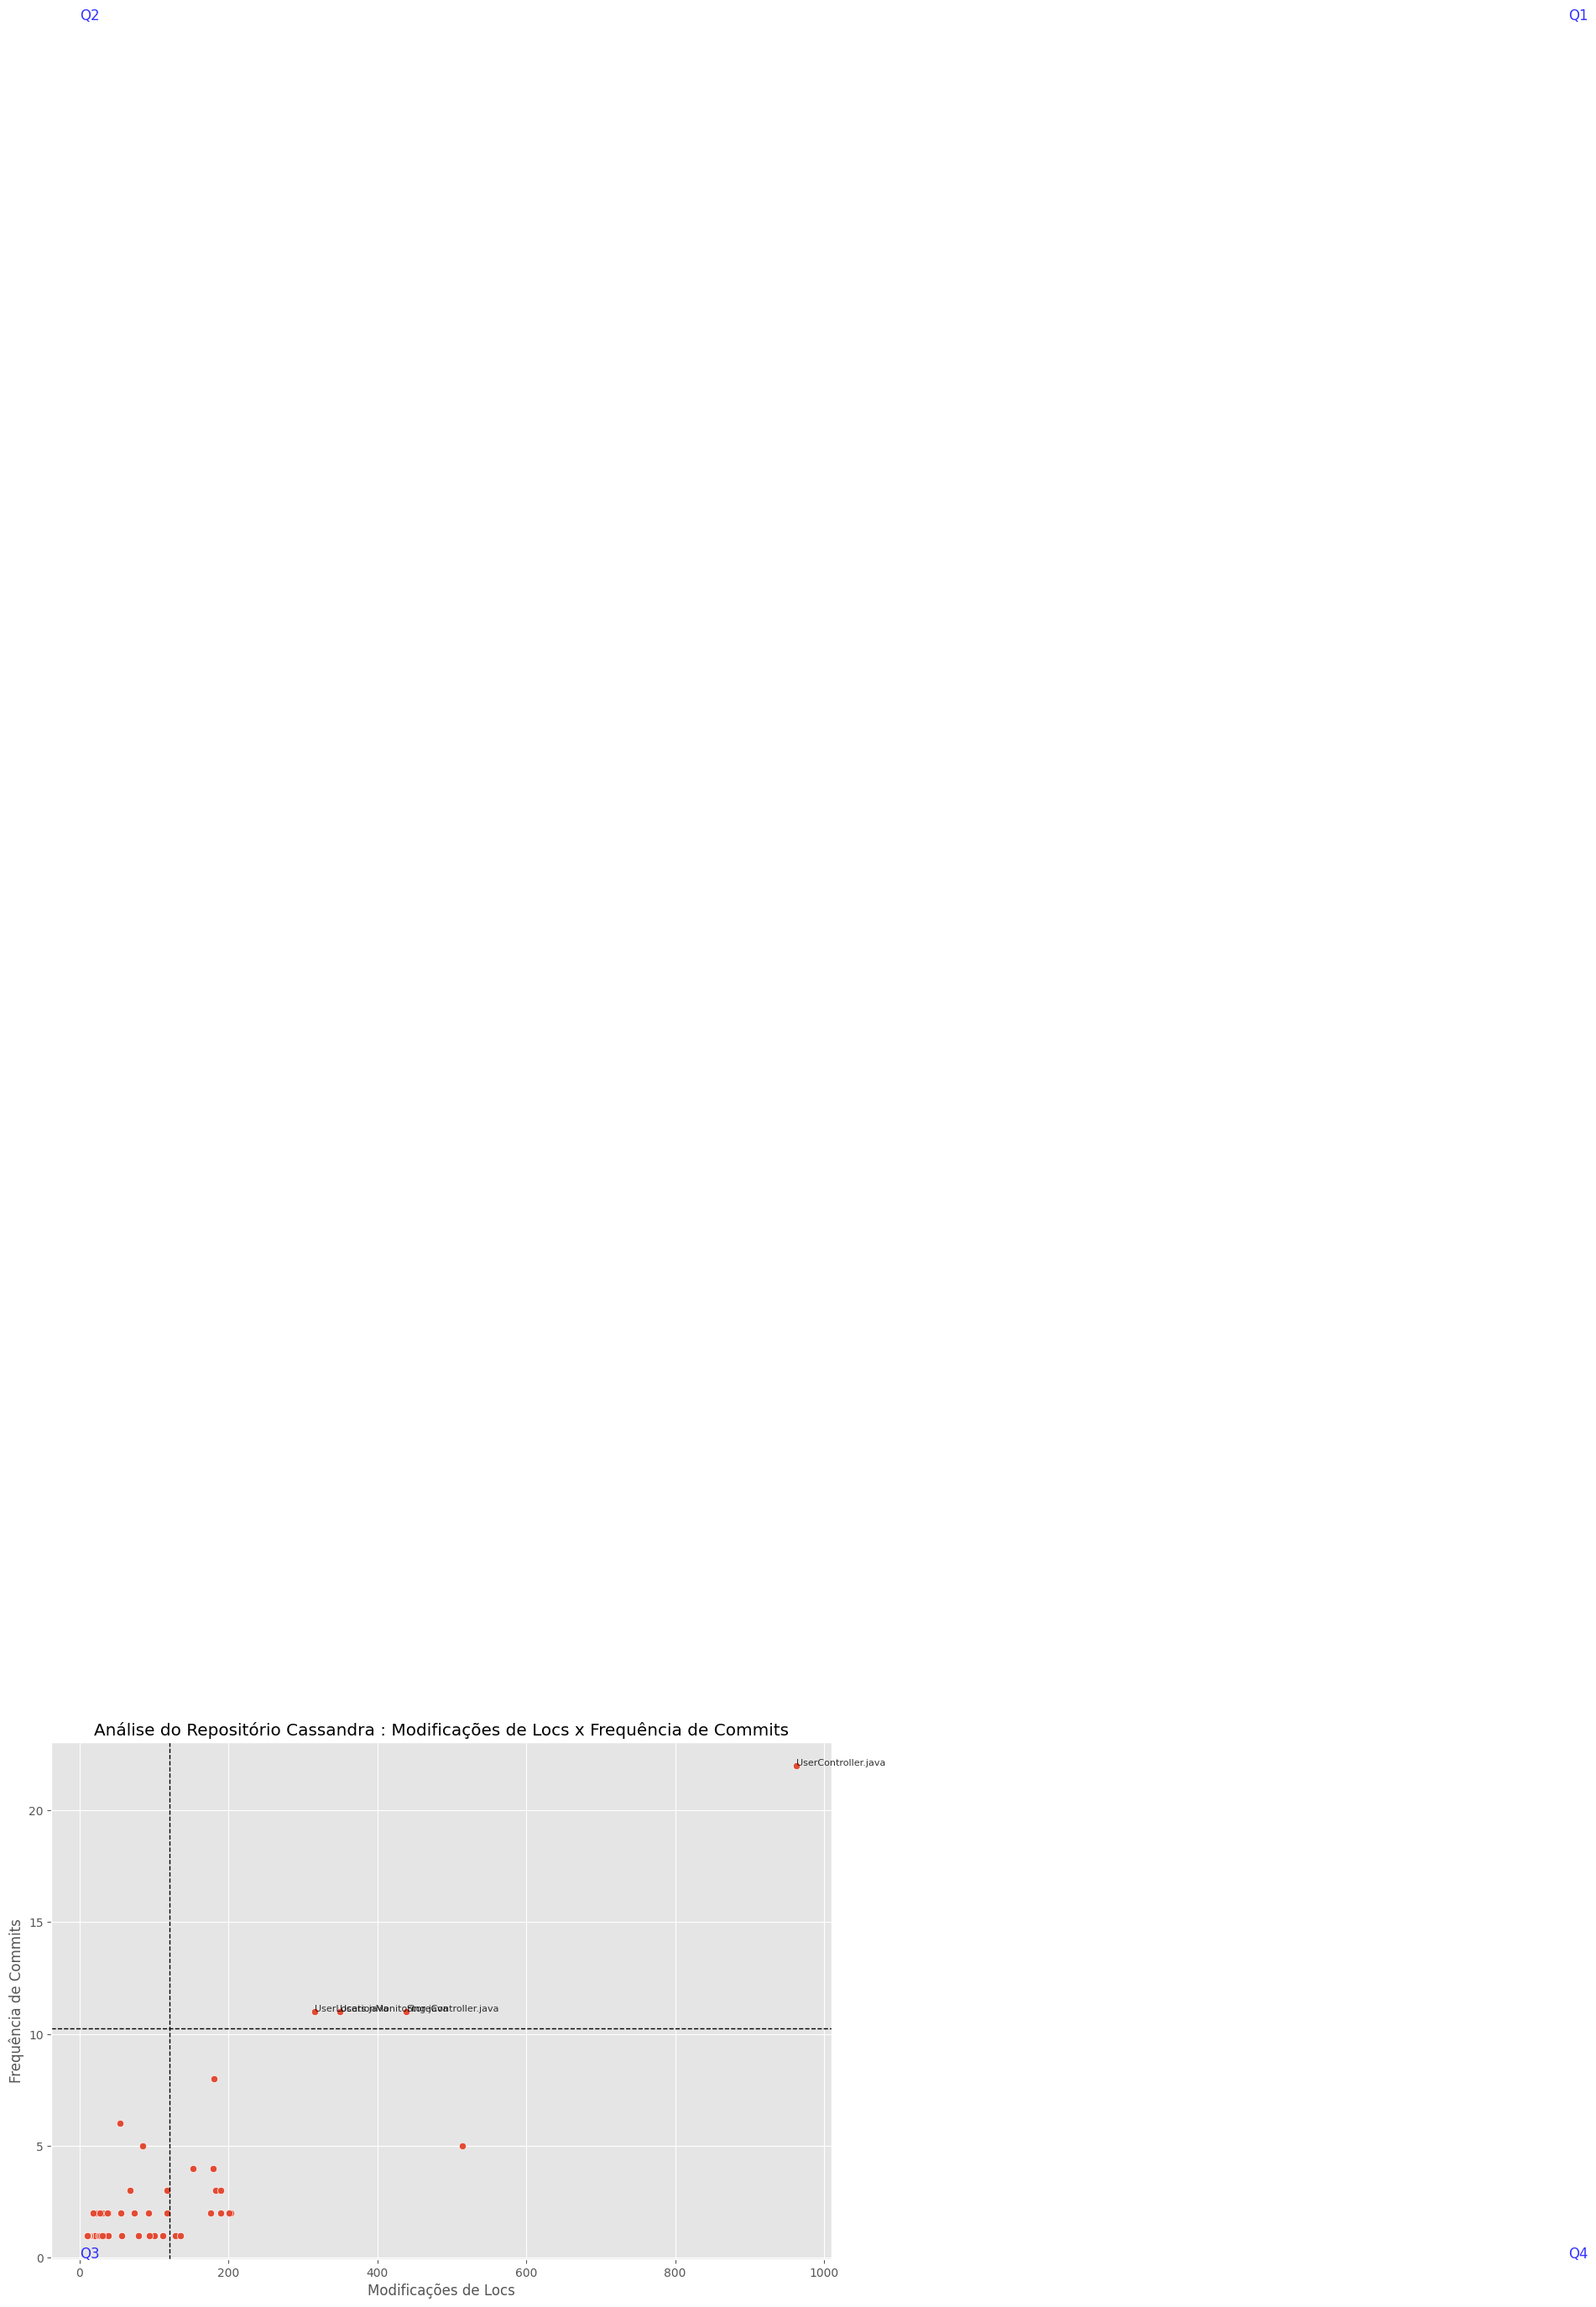

In [65]:
lista_temp_index_modified_lines = []
for items in df_em_fc_java_impl.modified_lines.iteritems():
  lista_temp_index_modified_lines.append((items[0], items[1]))

list_initial_critical_files_from_sp = []

plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_em_fc_java_impl, x='modified_lines', y='frequency_commits')

abbr={'titulo':'Modificações de LoCs x Frequência de Commits', 'modified_lines':'Modificações de Locs', 'frequency_commits':'Frequência de Commits'}

plt.title(f"Análise do Repositório Cassandra : {abbr['modified_lines']} x {abbr['frequency_commits']}")
plt.xlabel(abbr['modified_lines'])
plt.ylabel(abbr['frequency_commits'])
          
for i in lista_temp_index_modified_lines:
  if df_em_fc_java_impl.modified_lines[i[0]] > em_q3_java_impl and df_em_fc_java_impl.frequency_commits[i[0]] > fc_q3_java_impl: 
      plt.text(df_em_fc_java_impl.modified_lines[i[0]], y=df_em_fc_java_impl.frequency_commits[i[0]], s=df_em_fc_java_impl.name[i[0]], alpha=0.8, fontsize=8)
      list_initial_critical_files_from_sp.append( (df_em_fc_java_impl.name[i[0]], df_em_fc_java_impl.modified_lines[i[0]], df_em_fc_java_impl.frequency_commits[i[0]]) )

#Mean values          
plt.axvline(x=em_q3_java_impl, color='k',linestyle='--', linewidth=1) 
plt.axhline(y=fc_q3_java_impl, color='k', linestyle='--', linewidth=1)           

#Quadrant Marker          
plt.text(x=2000, y=100, s="Q1",alpha=0.8,fontsize=12, color='b')
plt.text(x=2000, y=0, s="Q4",alpha=0.8,fontsize=12, color='b')
plt.text(x=0, y=0, s="Q3", alpha=0.8,fontsize=12, color='b')
plt.text(x=0, y=100, s="Q2", alpha=0.8,fontsize=12, color='b')  

plt.show()

In [66]:
for item in list_initial_critical_files_from_sp:
  print(item)

('StoreController.java', 439, 11)
('UserController.java', 963, 22)
('UserLocationMonitoring.java', 316, 11)
('Users.java', 350, 11)


In [67]:
# Pego da secao de analise de Architectural Smells
# selecao de classes criticas que pertencem ao Q1 (quadrante1) -> Modified LOC ALTA e Frequencia de Commits Alta
my_temp_lista_arquivos_criticos = [("StorageService.java", 3537, 144), ("ColumnFamilyStore.java", 1966, 89), ("DatabaseDescriptor.java", 2092, 87), ("CompactionManager.java", 1279, 74), ("StorageProxy.java", 1667, 53), ("SSTableReader.java", 767, 53), ("Config.java", 553, 52), ("CassandraDaemon.java", 1001, 51), ("SelectStatement.java", 1174, 44), ("SinglePartitionReadCommand.java", 994, 38),("NodeProbe.java", 513, 37), ("MessagingService.java", 574, 36)]

my_temp_lista_arquivos_criticos_names = []
for i in range(0,  len(my_temp_lista_arquivos_criticos)):
  my_temp_lista_arquivos_criticos_names.append(my_temp_lista_arquivos_criticos[i][0])

<ipython-input-68-700f4ae71b6c>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



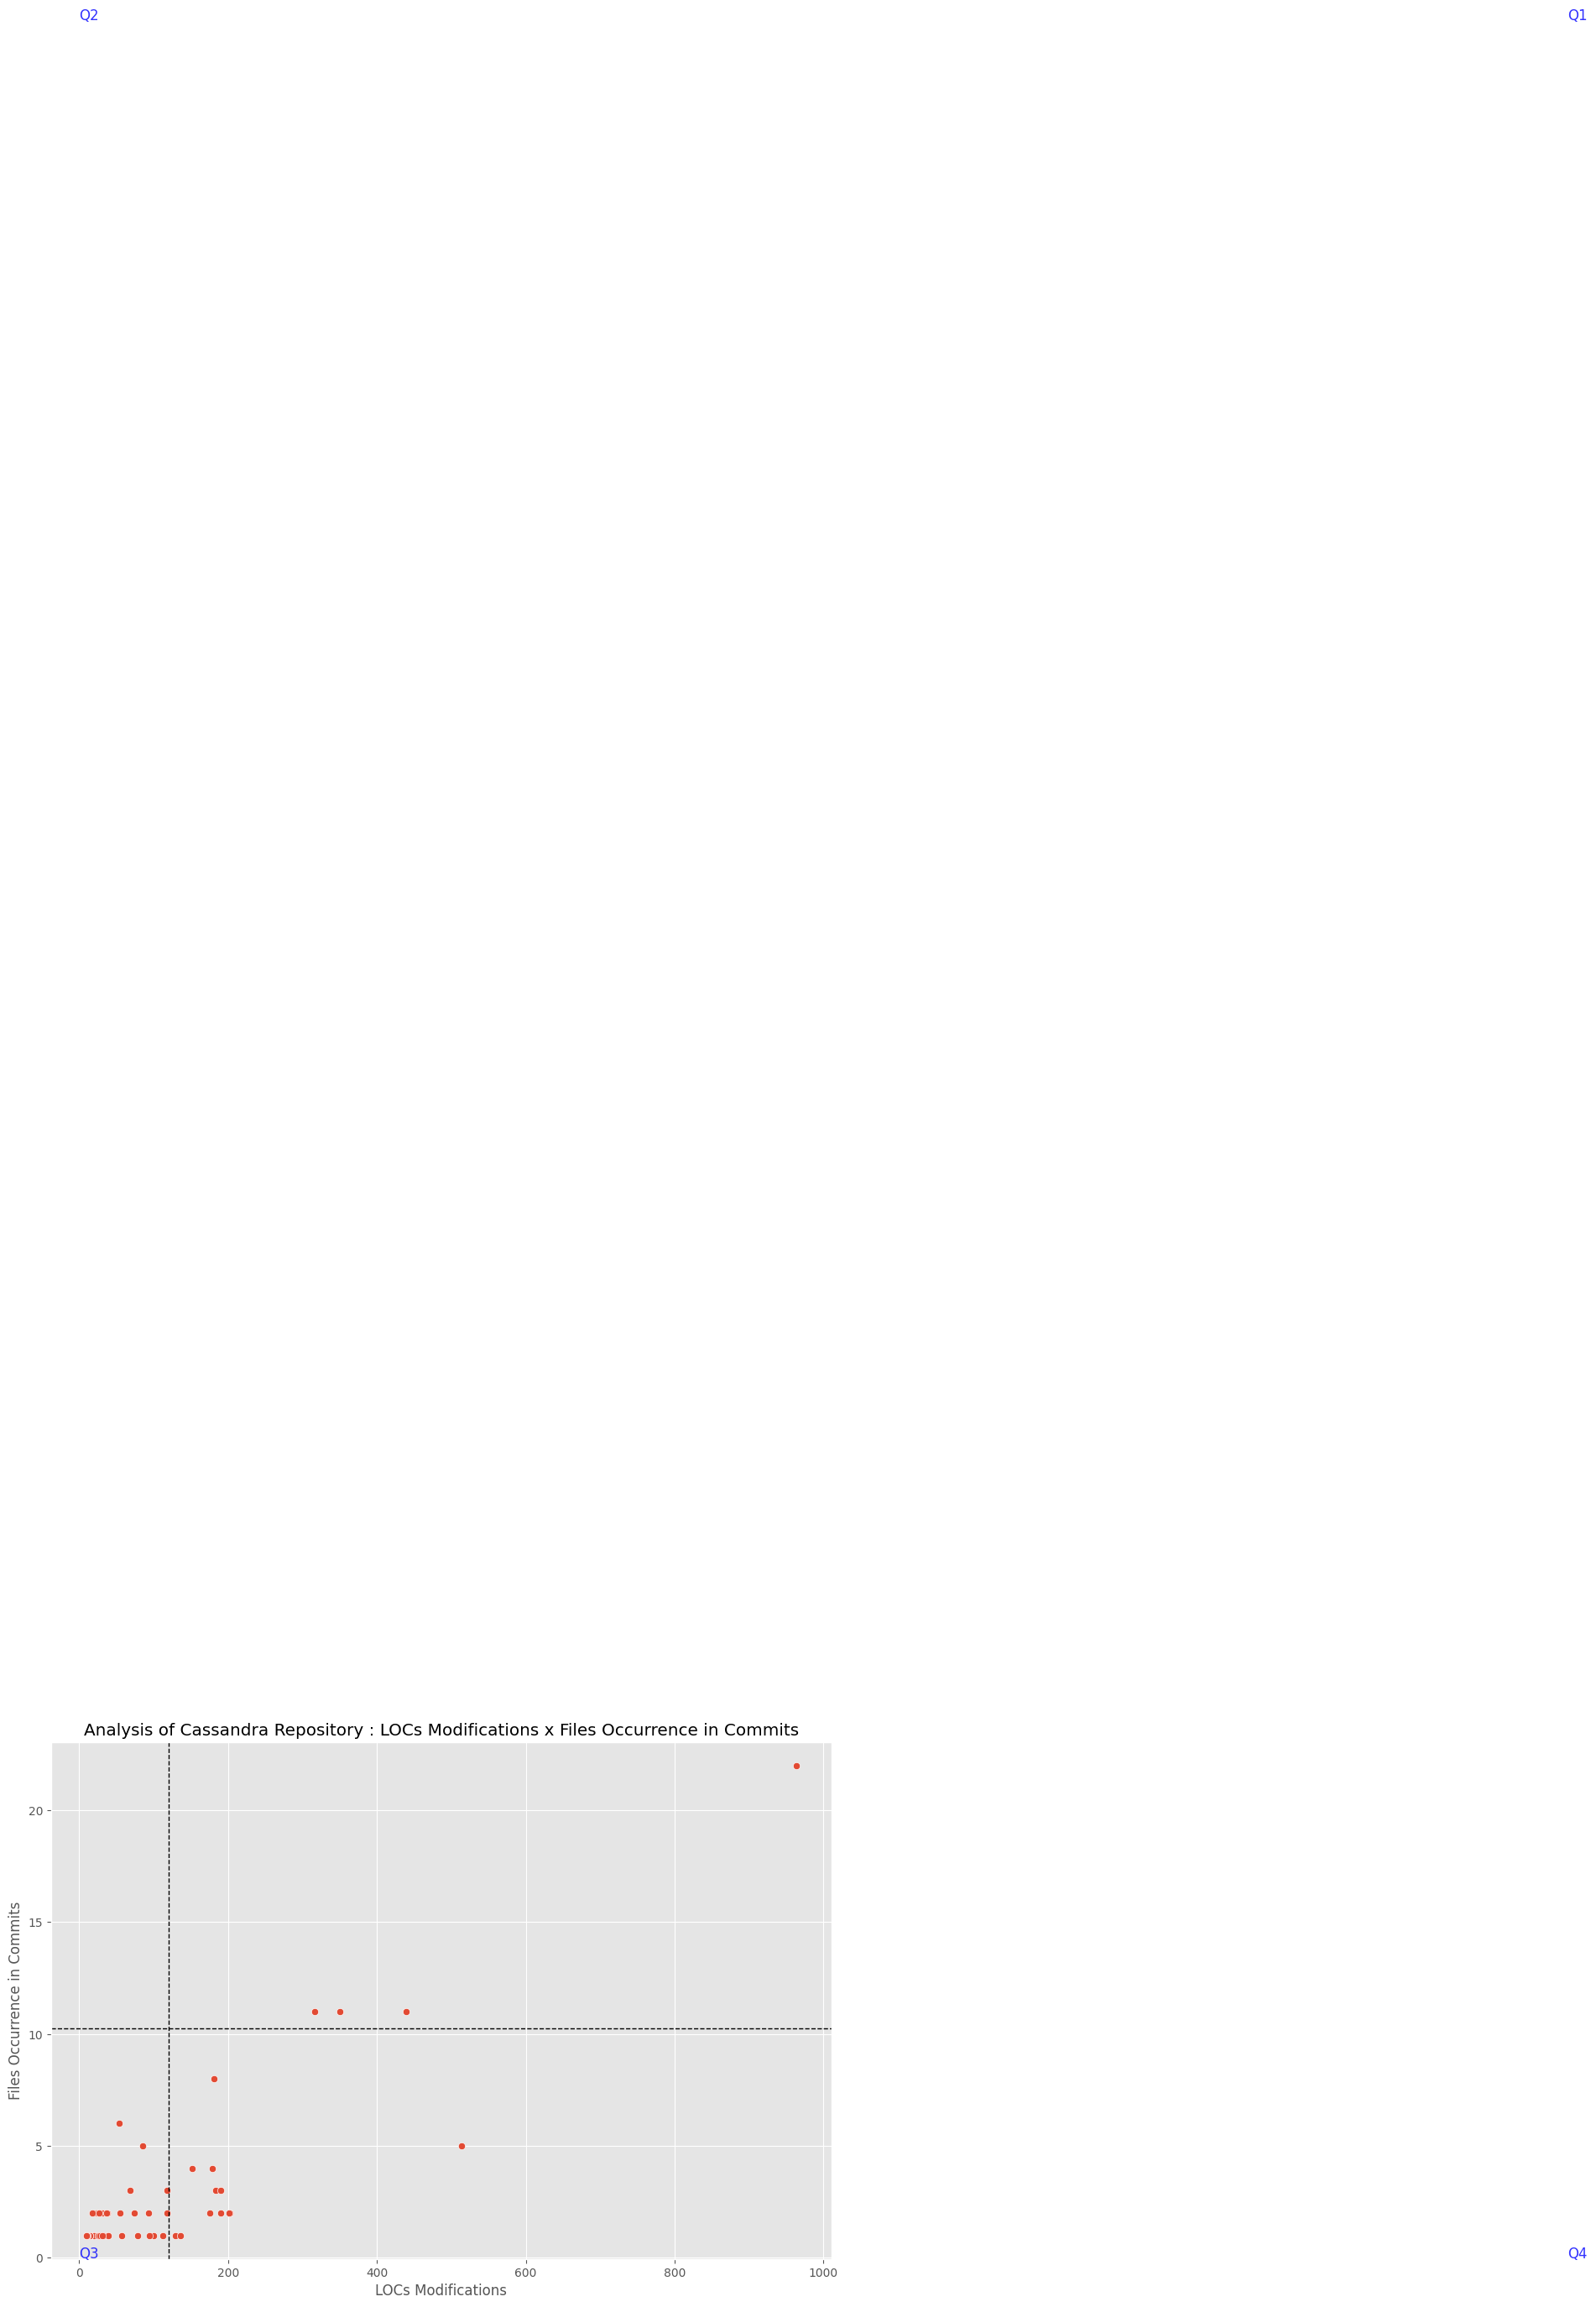

In [68]:
lista_temp_index_modified_lines = []
for items in df_em_fc_java_impl.modified_lines.iteritems():
  lista_temp_index_modified_lines.append((items[0], items[1]))

list_initial_critical_files_from_sp = []

plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_em_fc_java_impl, x='modified_lines', y='frequency_commits')

abbr={'titulo':'LOCs Modifications x Files Occurrence in Commits', 'modified_lines':'LOCs Modifications', 'frequency_commits':'Files Occurrence in Commits'}

plt.title(f"Analysis of Cassandra Repository : {abbr['modified_lines']} x {abbr['frequency_commits']}")
plt.xlabel(abbr['modified_lines'])
plt.ylabel(abbr['frequency_commits'])
          
for i in lista_temp_index_modified_lines:
  if df_em_fc_java_impl.modified_lines[i[0]] > em_q3_java_impl and df_em_fc_java_impl.frequency_commits[i[0]] > fc_q3_java_impl: 
    if df_em_fc_java_impl.name[i[0]] in my_temp_lista_arquivos_criticos_names:
      plt.text(df_em_fc_java_impl.modified_lines[i[0]], y=df_em_fc_java_impl.frequency_commits[i[0]], s=df_em_fc_java_impl.name[i[0]], alpha=0.8, fontsize=8)

#Mean values          
plt.axvline(x=em_q3_java_impl, color='k',linestyle='--', linewidth=1) 
plt.axhline(y=fc_q3_java_impl, color='k', linestyle='--', linewidth=1)           

#Quadrant Marker          
plt.text(x=2000, y=100, s="Q1",alpha=0.8,fontsize=12, color='b')
plt.text(x=2000, y=0, s="Q4",alpha=0.8,fontsize=12, color='b')
plt.text(x=0, y=0, s="Q3", alpha=0.8,fontsize=12, color='b')
plt.text(x=0, y=100, s="Q2", alpha=0.8,fontsize=12, color='b')  

plt.savefig('scatter_plot_mloc_foc.png')
plt.show()

In [69]:
import plotly.graph_objects as go

#https://plotly.com/python/line-and-scatter/
#https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
#https://plotly.com/python/creating-and-updating-figures/
#https://plotly.com/python/setting-graph-size/
#https://plotly.com/python/axes/
#https://www.linkedin.com/pulse/complete-introduction-plotly-from-beginner-advanced-pranjall-kumar

# array de complexidade ciclomatica
array_cc = np.random.randint(1, 300, size=300)
# Add traces
fig = go.Figure(data=go.Scatter(
                    x=df_em_fc_java_impl.modified_lines, 
                    y=df_em_fc_java_impl.frequency_commits,
                    mode='markers',
                    name='markers',
                    customdata=df_em_fc_java_impl.name,
                    hovertext=df_em_fc_java_impl.name, 
                    marker=dict(size=8, color=array_cc, colorscale='Blues', showscale=True, colorbar={"title": 'CC'})
                    )
                  )

fig.update_layout({"title_text": "LoC Mofications x Commit Frequency"},     
                  width=1000,
                  height=600
                  )
fig.update_xaxes(
        title_text = "LoC Modifications",
        title_font = {"size": 10}
        )
fig.update_yaxes(
        title_text = "Commit Frequency",
        title_font = {"size": 10}
        )

fig.show()

In [70]:
array_cc

array([ 44, 208, 245, 198,   8,  47,  79,  10, 293, 196,  28,  99, 202,
       237, 264, 278,  20, 258, 118,  60, 272, 110, 159, 284, 213, 109,
        13,  28,  37, 182, 208,  35,  33, 196,  67, 144,  16, 165,  82,
       226, 274, 224,  30, 276,  70, 282, 269, 159, 187, 175, 266, 214,
       130, 298,  88,  23,  60, 222, 237, 125, 206,  11, 274,  86, 137,
        93, 139, 276,  96, 216, 180, 175, 120, 276, 245, 298, 282,  80,
       128, 292,  44, 212, 148, 162,  61,  95, 200,  51, 160, 135, 284,
        30, 153, 163, 261, 116,  11, 210, 241,   3,  79,  20,  26,  97,
       211, 128, 205, 130, 209, 172, 189, 236,  61,   2, 274, 191, 251,
         6, 202,  15, 163, 260,  11,  12, 237, 108, 247, 226,  20, 172,
       219, 111, 265, 157, 222,  51, 157, 181,  43, 281, 108,  71, 239,
       186, 253, 110,  33,  36, 284, 224, 106, 110, 261, 142,  50, 202,
         5, 290, 268, 217, 169, 283, 222,  12, 223,  33,  25, 287,  63,
       106, 298,  43, 155, 173, 206, 237,  68, 126,   4,  46, 18

# Creating the Dependency Matrix (DSM) (step 15)

DSM: fa depends on fb

	   f1 f2 f3 ... fn

f1   x  1  0 ...  0

f2   0  x  1 ...  1

f3   0  0  x ...  0

f1 depends on f2, f2 depends on f3

DSM1 ( dicionario_dsm['fa'] ) -> given the file fa returns all files that fa uses

DSM2 ( dicionario_dsm_depende_de['fa'] ) -> given file fa returns all files that depend on fa

In [71]:
# Gera um arquivo contendo todos os arquivos .java do projeto Cassandra
!find promocity/src/main/java/ufc/cmu/promocity -name "*.java" > arquivosjava.txt

In [72]:
# Mostra os 10 primeiros arquivos .java 
!head -10 arquivosjava.txt

promocity/src/main/java/ufc/cmu/promocity/backend/repository/MyStoresRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/UsersRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/StoresRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/CouponsRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/TrackRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/MyTrackingRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/repository/PromotionsRepository.java
promocity/src/main/java/ufc/cmu/promocity/backend/service/BookService.java
promocity/src/main/java/ufc/cmu/promocity/backend/service/MyStoresService.java
promocity/src/main/java/ufc/cmu/promocity/backend/service/interfaces/IPromotionService.java


In [74]:
# Cria duas listas contendo o conjunto de arquivos da versão analisada
lista_linhas_arquivos_cassandra = []
lista_colunas_arquivos_cassandra = []

with open('arquivosjava.txt', mode='r+', encoding='utf-8') as file:
  for line in file:  
    line = line.rstrip()
    line = line.replace('promocity/src/main/java/', '')
    line = line.replace('/', '.')
    lista_linhas_arquivos_cassandra.append(line)
    lista_colunas_arquivos_cassandra.append(line)

In [75]:
# Dado 'org.apache.cassandra.index.Index.java'
# Retorne 'pilot/analises/designite/v-3-11-11/src/java/org/apache/cassandra/index/Index.java'

def get_path_file(my_file, src_java_path='promocity/src/main/java/'):
  path_file = None
  my_file = my_file.replace('.java', '') # org.apache.cassandra.index.Index
  my_file = my_file.replace('.', '/') # org/apache/cassandra/index/Index
  my_file = my_file + '.java' # org/apache/cassandra/index/Index.java
  path_file =  src_java_path  + my_file 
  return path_file

def teste_find_word_in_file(my_file, my_word):
    with open(my_file) as f:
        datafile = f.readlines()
        found = False  # This isn't really necessary
        for line in datafile:
          if my_word in line:
            # found = True # Not necessary
            return True
    return False  # Because you finished the search without finding
  
def lista_arquivos_que_dependem_de(my_file, dicionario):
  lista_temp = []
  my_file = my_file.replace('/','.')
  if my_file in dicionario:
    for each in dicionario[my_file]:
      if each[2] == 1: 
        lista_temp.append(each)
  return lista_temp

## DSM File A uses File B

In [76]:
import datetime

t1 = datetime.datetime.now()

dicionario_dsm = {}
lista_aux = []

for each_file in lista_linhas_arquivos_cassandra:
  for each_elemento_coluna in lista_colunas_arquivos_cassandra:
    my_search = each_elemento_coluna
    my_search = my_search.replace('.java', ';')
    my_path = get_path_file(my_file=each_file)
    if teste_find_word_in_file(my_file=my_path,my_word=my_search):
      item = (each_file, each_elemento_coluna, 1)
    else:
      item = (each_file, each_elemento_coluna, 0)
    lista_aux.append(item)
  dicionario_dsm[each_file] = lista_aux 
  lista_aux = []
  
t2 = datetime.datetime.now()

delta = t2 - t1

print(f'Tempo para criar o dicionarário dsm: {delta}, itens percorridos: {len(dicionario_dsm)}')

Tempo para criar o dicionarário dsm: 0:00:00.200098, itens percorridos: 60


In [77]:
temp = 'ufc.cmu.promocity.backend.controller.UserController.java'
temp = temp.replace('/','.')
print(dicionario_dsm[temp])

[('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.MyStoresRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.UsersRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.StoresRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.CouponsRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.TrackRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.MyTrackingRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.repository.PromotionsRepository.java', 0), ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.BookS

In [78]:
# Exemplo: Relação de Arquivos que MessagingService.java depende

i = 1
for tupla in dicionario_dsm[temp]:
  if tupla[2] == 1:
    print(f'{i}, {tupla}')
    i = i + 1

1, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.MyStoresService.java', 1)
2, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.StoreService.java', 1)
3, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.CouponsService.java', 1)
4, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.UsersService.java', 1)
5, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.MyTrackingService.java', 1)
6, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.PromotionsService.java', 1)
7, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.service.TrackService.java', 1)
8, ('ufc.cmu.promocity.backend.controller.UserController.java', 'ufc.cmu.promocity.backend.context.UserLocationMonitoring.java', 1)

## DSM File A depends on File B

In [79]:
t1 = datetime.datetime.now()

dicionario_dsm_depende_de = {}
lista_aux = []

for each_file in lista_linhas_arquivos_cassandra:
  for each_elemento_coluna in lista_colunas_arquivos_cassandra:
    my_search = each_file
    my_search = my_search.replace('.java', ';')
    my_path = get_path_file(my_file=each_elemento_coluna)
    if teste_find_word_in_file(my_file=my_path,my_word=my_search):
      item = (each_elemento_coluna, each_file, 1)
    else:
      item = (each_elemento_coluna, each_file, 0)
    lista_aux.append(item)
  dicionario_dsm_depende_de[each_file] = lista_aux 
  lista_aux = []
  
t2 = datetime.datetime.now()

delta = t2 - t1

print(f'Tempo para criar o dicionarário dsm: {delta}, itens percorridos: {len(dicionario_dsm_depende_de)}')

Tempo para criar o dicionarário dsm: 0:00:00.136055, itens percorridos: 60


In [81]:
# Exemplo: Relação de Arquivos que dependem de UserController.java

i = 1
for tupla in lista_arquivos_que_dependem_de(my_file='ufc.cmu.promocity.backend.controller.UserController.java', dicionario=dicionario_dsm_depende_de):
  if tupla[2] == 1:
    print(f'{i}, {tupla}')
    i += 1

1, ('ufc.cmu.promocity.backend.JerseyConfiguration.java', 'ufc.cmu.promocity.backend.controller.UserController.java', 1)
